<font color="Green"><h1> **Intro to Deep Learning Mini Project - Cancer Detection**</h1></font>
<font color="Green"><h2> **Github Link**</h2></font>
<p><a href = "https://github.com/Connor-Crosslin/Cancer-detection">Github Link</a></p>

In [1]:
#import necessary libraries

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random

from os import listdir
from pandas import read_csv
from keras import layers, Sequential, optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.utils import plot_model

2024-06-18 05:19:28.135727: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 05:19:28.135896: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 05:19:28.312688: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<font color="Green"><h2> **Problem Statement**</h2></font>
<p>
Given a set of scan images, predict which are likely to have cancer. This project will construct a convolutional neural network to try and predict whether or not cancer exists. Convolutional neural networks are an "expansion" of classical nerual networks. They impose a filter to learn the weights and biases of the model rather than just the plain-Jane neurons in a vanilla ANN. These filters traverse the image (fed into the networks as an array typically) and give outputs to the next layer of some size. Charecteristics of the CNN include stride length and filter size for tuning. At its core this is a binary classification problem.
</p>

<font color="Green"><h2> **Exploratory Data Analysis and Preprocessing**</h2></font>

In [2]:
train_directory = "/kaggle/input/histopathologic-cancer-detection/train/"
test_directory = "/kaggle/input/histopathologic-cancer-detection/test/"
train_labels_df = read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

In [3]:
#check out the label data

print(train_labels_df.head(), '\n')
print('/r', train_labels_df.info(), '\n')
print(train_labels_df.describe(), '\n')

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
/r None 

               label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000 



In [4]:
#cycle through our labels and remove the file extension from the end

train_labels_df['with_ext'] = train_labels_df['id'].apply(lambda x: x + '.tif')

In [5]:
#preprocess our training dataset
#convert our images to numpy arrays so our model can use them

#limit our training size due to kaggle memory constraints

num_train_img = 7500 #len(listdir(train_directory))
X_train = np.empty((num_train_img, 96,96,3))
Y_train = np.empty((num_train_img, 1))
index = 0

for image_file in listdir(train_directory):
    X_train[index] = cv2.imread(train_directory + image_file)
    Y_train[index] = float(train_labels_df.loc[train_labels_df['with_ext'] == image_file]['label'].iloc[0])
    index += 1
    if index == num_train_img:
        break

In [6]:
# we are done with train_labels_df, delete due to kaggle memory constraints
del train_labels_df

In [7]:
#similarly, load our test images

num_test_img = len(listdir(test_directory))
X_test = np.empty((num_test_img, 96,96,3))
index = 0

for image_file in listdir(test_directory):
    X_test[index] = cv2.imread(test_directory + image_file)
    index += 1


In [8]:
#rescale our datasets

X_train = X_train/255.0
X_test = X_test/255.0   

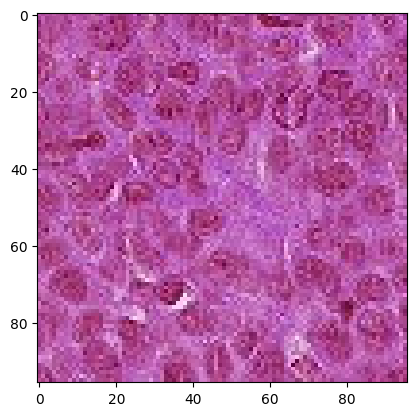

In [9]:
#rerun this cell to see random images form our train set (and to verify we preprocessed correctly)

rand_ind = random.randint(0, len(X_train))
plt.imshow(X_train[rand_ind,:])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

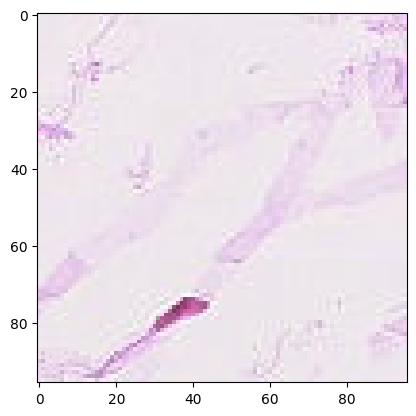

In [10]:
#rerun this cell to see random images form our test set (and to verify we preprocessed correctly)

rand_ind = random.randint(0, len(X_test))
plt.imshow(X_test[rand_ind,:])
plt.show

<font color="Green"><h2> **Model Architecture (Build the Model)**</h2></font>
<p>We use simple convolutional neural network to build the model with activation layer relu. Relu is used to hopefully reduce computational load and is a simple straighforward activation function with $f(x)=max(0,x)$. We set a relatively large filter due tot he fact that we primarily care about the inner 32x32 region of the image, not the outside.

In [11]:
#build the model

model = Sequential([
    Conv2D(32, (9,9), activation = 'relu', input_shape = (96, 96, 3)),
    MaxPooling2D((2,2)),
    Conv2D(32, (9,9), activation = 'relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 88, 88, 32)     │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 44, 44, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 36, 36, 32)     │        82,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       663,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 754,465 (2.88 MB)

 Trainable params: 754,465 (2.88 MB)

 Non-trainable params: 0 (0.00 B)

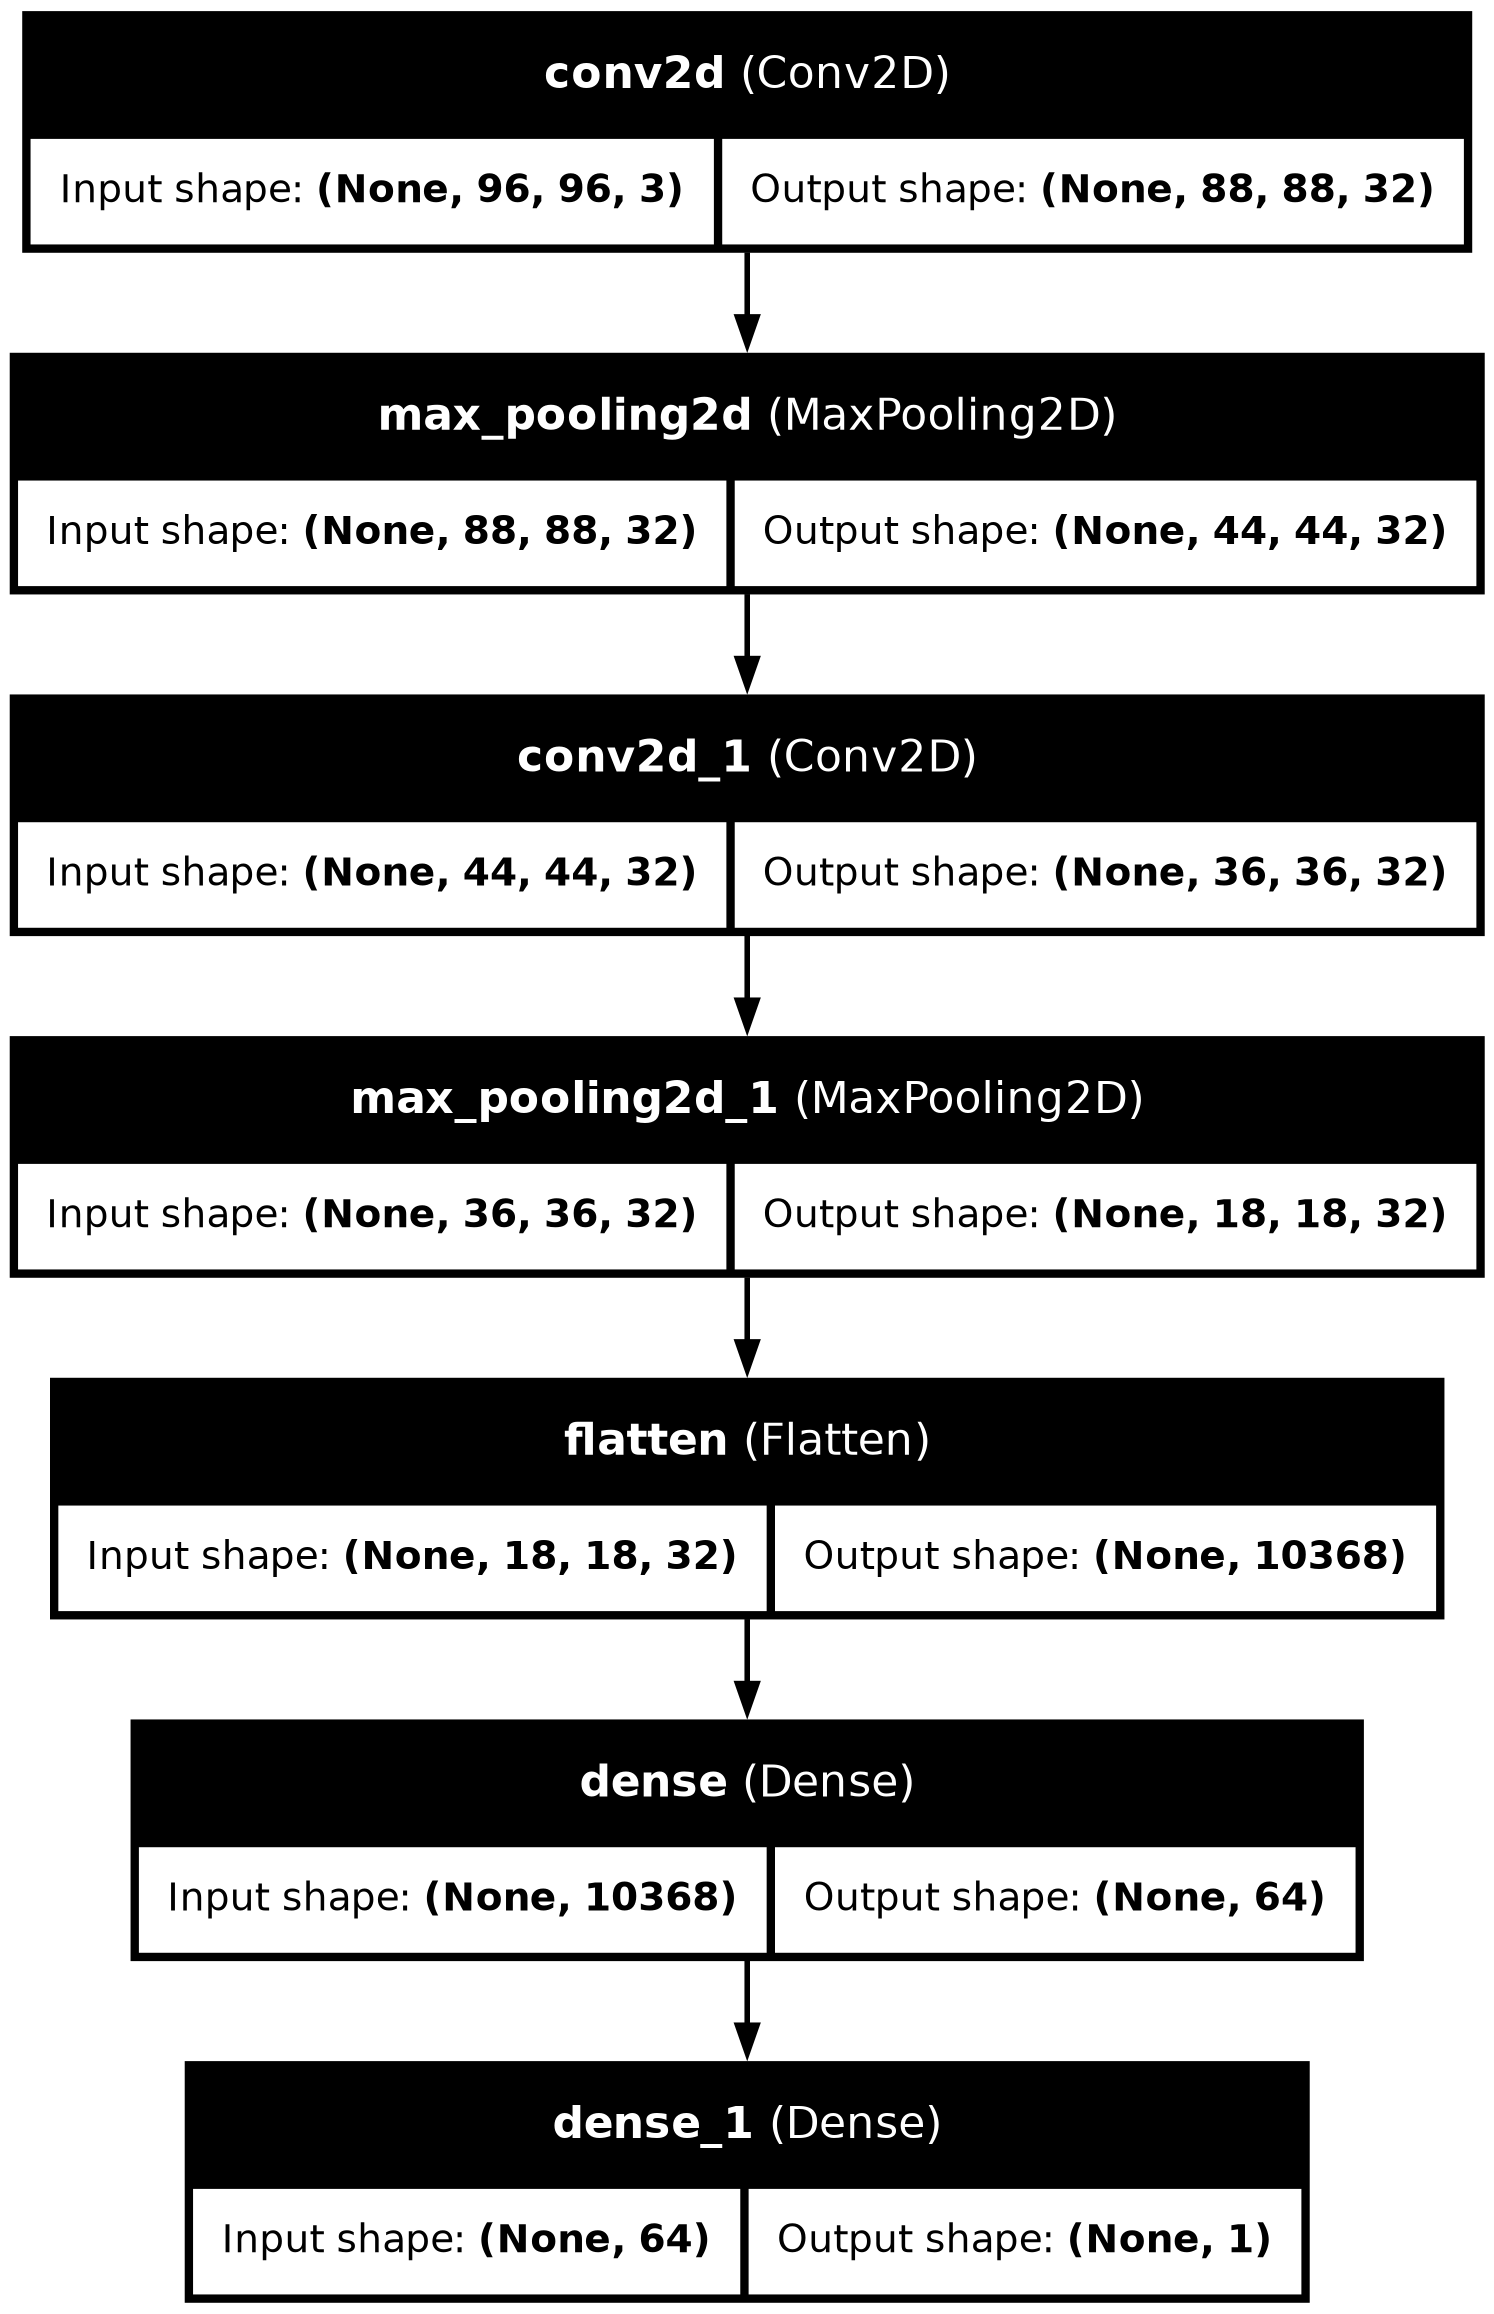

In [13]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [14]:
#set our optimizer
#use binary cross-entropy loss for binary classification problem
#use stochastic Gradient descent

opt = optimizers.SGD(learning_rate = 0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
#fit the model

model.fit(x=X_train, y=Y_train, batch_size= 250, epochs=20)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 0.5570 - loss: 0.6825
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.5871 - loss: 0.6721
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 135s 5s/step - accuracy: 0.5965 - loss: 0.6652
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.6072 - loss: 0.6591
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step - accuracy: 0.5893 - loss: 0.6640
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 134s 4s/step - accuracy: 0.5979 - loss: 0.6602
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 134s 4s/step - accuracy: 0.5986 - loss: 0.6573
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 136s 5s/step - accuracy: 0.5847 - loss: 0.6595
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - accuracy: 0.5866 - loss: 0.6569
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 140s 5s/step - accuracy: 0.5965 - loss: 0.6504
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step - accuracy: 0.5968 - loss: 0.6482
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 134s 4s/step - accuracy:

In [16]:
#delete for memory purposes

del X_train
del Y_train

In [17]:
#feed our test set to the model one by one to save memory

a = np.empty((len(X_test)))
for pred in range(len(X_test)):
    a[pred] = model.predict(X_test[pred:pred + 1], verbose = 0)
    

/tmp/ipykernel_18/1971689340.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a[pred] = model.predict(X_test[pred:pred + 1], verbose = 0)


In [18]:
#export our results

np.savetxt('submission.csv', a, delimiter = ',')

<font color="Green"><h2> **Conclusion**</h2></font>
<p>In general, memory constraints were a problem for this project. If we had utilized the entire dataset, I am confident that SGD would eventually lead to a much better accuracy score. The result was not terrible given the smaller training dataset. For the next pass could find a method of borrowing processing power from other cloud sources.